### Proportion of UK area over high and extreme thresholds (including uncertainty)

##### Preliminaries

In [2]:
import scipy.stats
import math
import xarray
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings
import matplotlib as mpl
import warnings
import cmasher as cmr
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FormatStrFormatter

In [3]:
def get_lat_lon_ukcp(grid_lat,grid_lon):
    rlon = grid_lon * np.pi/180
    rlat = grid_lat * np.pi/180
    
    theta = -(90 - 39.25) * np.pi/180
    phi = -(180 - 162) * np.pi/180
    x = np.outer(np.cos(rlat),np.cos(rlon))
    y = np.outer(np.cos(rlat),np.sin(rlon))
    z = np.outer(np.sin(rlat),np.ones(len(rlon)))

    x_new = np.cos(theta) * np.cos(phi) * x + np.sin(phi) * y + np.sin(theta) * np.cos(phi) * z
    y_new = -np.cos(theta) * np.sin(phi) * x + np.cos(phi) * y - np.sin(theta) * np.sin(phi) * z
    z_new = -np.sin(theta) * x + np.cos(theta) * z
    
    lons = np.arctan(np.divide(y_new, x_new)) * 180/np.pi
    lats = np.arcsin(z_new) * 180/np.pi
    
    return lons,lats


def get_cordex_addresses():
    models = pd.read_csv('cordex_models.txt', sep='\t')

    # Getting file strings:
        # Directories:
    root = '/data/met/ukcordex/'
    directories = [root + models['GCM'][i] + '/' +
                   models['RCM'][i] + '/' +
                   models['Ensemble'][i] + '/dmo/'
                   for i in range(models.shape[0])]

        # Filenames:
    #feat. clunky for loops and error handling!
    tas_files  = []
    hurs_files = []
    pr_files   = []
    wind_files = []
    err_indexs = []
    print(type(err_indexs))
    for i in range(models.shape[0]):
        try:
            for f_name in os.listdir(directories[i]):
                if f_name.startswith('tas_'):
                    tas_files.append(str(f_name))
                if f_name.startswith('hurs_'):
                    hurs_files.append(str(f_name))
                if f_name.startswith('sfcWind_'):
                    wind_files.append(str(f_name))
                if f_name.startswith('pr_'):
                    pr_files.append(str(f_name))

        except OSError as error:
            print(f'Inelligible directory at: {directories[i]}')
            err_indexs.append(int(i))


    for i in range(len(err_indexs)):
        del directories[err_indexs[i]]
    
    return directories,tas_files,hurs_files,wind_files,pr_files



def earth_radius(lat):
    # From: https://towardsdatascience.com/the-correct-way-to-average-the-globe-92ceecd172b7
    a = 6378137
    b = 6356752.3142
    e2 = 1 - (b**2/a**2)
    lat = np.deg2rad(lat)
    lat_gc = np.arctan( (1-e2)*np.tan(lat) )

    # radius equation
    # see equation 3-107 in WGS84
    r = (
        (a * (1 - e2)**0.5) 
         / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
        )

    return r


def area_grid(lats,lons):
    # Adapted rom: https://towardsdatascience.com/the-correct-way-to-average-the-globe-92ceecd172b7
    R = earth_radius(lats)
    dlat = np.deg2rad(np.gradient(lats, axis=0))
    dlon = np.deg2rad(np.gradient(lons, axis=1))
    dy = dlat * R
    dx = dlon * R * np.cos(np.deg2rad(lats))
    area_weights = dy * dx
    
    return area_weights

#### EuroCORDEX: UK root image 

In [20]:
# Loading Data:

fwi = np.load('/home/theo/outdata/2.1.outdata/ukcordex_regional_fwi_severity_by_area.npy')[:,1:49,:,:]
fwi = fwi/np.sum(fwi,axis=0)
print(fwi.shape)

#fwi_med  = np.percentile(fwi,50,axis=1)
#fwi_up   = np.percentile(fwi,84,axis=1) # z = 1
#fwi_lo   = np.percentile(fwi,16,axis=1) # z = -1

(6, 48, 17, 100)


In [13]:
fwi_lo_100  = np.empty((6,17,100))
fwi_mid_100 = np.empty((6,17,100))
fwi_hi_100  = np.empty((6,17,100))

fwi_lo_75  = np.empty((6,17,100))
fwi_mid_75 = np.empty((6,17,100))
fwi_hi_75  = np.empty((6,17,100))

fwi_lo_50  = np.empty((6,17,100))
fwi_mid_50 = np.empty((6,17,100))
fwi_hi_50  = np.empty((6,17,100))

fwi_lo_25  = np.empty((6,17,100))
fwi_mid_25 = np.empty((6,17,100))
fwi_hi_25  = np.empty((6,17,100))

for i in range(6):
    print(f'Step {i+1} of 6')
    for j in range(100):
        if np.mod(j,10) == 0:
            print(f'Sub-step {int(j/10 + 1)} of 10')
        for k in range(17):
            
            shape, location, scale = scipy.stats.lognorm.fit(fwi[i,:,k,j])
            #x = np.linspace(scipy.stats.lognorm.ppf(0.00001, shape),scipy.stats.lognorm.ppf(0.99999, shape), 100000)
            x = np.linspace(0,2*np.max(fwi[i,:,k,j]),100000)
            cdf = scipy.stats.lognorm.cdf(x, shape, location, scale)
            pdf = scipy.stats.lognorm.pdf(x, shape, location, scale)
            
            # 100% interval:
            arg_lo_100 = np.argmin(np.absolute(cdf-0.00))
            arg_mid_100= np.argmin(np.absolute(cdf-0.50))
            arg_hi_100 = np.argmin(np.absolute(cdf-1.00))

            fwi_lo_100[i,k,j] = x[arg_lo_100]
            fwi_mid_100[i,k,j]= x[arg_mid_100]
            fwi_hi_100[i,k,j] = x[arg_hi_100]
            
            # 75% interval:
            arg_lo_75 = np.argmin(np.absolute(cdf-0.125))
            arg_mid_75= np.argmin(np.absolute(cdf-0.50))
            arg_hi_75 = np.argmin(np.absolute(cdf-0.875))

            fwi_lo_75[i,k,j] = x[arg_lo_75]
            fwi_mid_75[i,k,j]= x[arg_mid_75]
            fwi_hi_75[i,k,j] = x[arg_hi_75]
        
            # 50% interval:
            arg_lo_50 = np.argmin(np.absolute(cdf-0.25))
            arg_mid_50= np.argmin(np.absolute(cdf-0.50))
            arg_hi_50 = np.argmin(np.absolute(cdf-0.75))

            fwi_lo_50[i,k,j] = x[arg_lo_50]
            fwi_mid_50[i,k,j]= x[arg_mid_50]
            fwi_hi_50[i,k,j] = x[arg_hi_50]
        
            # 25% interval:
            arg_lo_25 = np.argmin(np.absolute(cdf-0.375))
            arg_mid_25= np.argmin(np.absolute(cdf-0.50))
            arg_hi_25 = np.argmin(np.absolute(cdf-0.625))

            fwi_lo_25[i,k,j] = x[arg_lo_25]
            fwi_mid_25[i,k,j]= x[arg_mid_25]
            fwi_hi_25[i,k,j] = x[arg_hi_25]
        
        
print(fwi_lo_25.shape,  np.min(fwi_lo_25),  np.max(fwi_lo_25))
print(fwi_mid_25.shape, np.min(fwi_mid_25), np.max(fwi_mid_25))
print(fwi_hi_25.shape,  np.min(fwi_hi_25),  np.max(fwi_hi_25))

Step 1 of 6
Sub-step 1 of 10
Sub-step 2 of 10
Sub-step 3 of 10
Sub-step 4 of 10
Sub-step 5 of 10
Sub-step 6 of 10
Sub-step 7 of 10
Sub-step 8 of 10
Sub-step 9 of 10
Sub-step 10 of 10
Step 2 of 6
Sub-step 1 of 10
Sub-step 2 of 10
Sub-step 3 of 10
Sub-step 4 of 10
Sub-step 5 of 10
Sub-step 6 of 10
Sub-step 7 of 10
Sub-step 8 of 10
Sub-step 9 of 10
Sub-step 10 of 10
Step 3 of 6
Sub-step 1 of 10
Sub-step 2 of 10
Sub-step 3 of 10
Sub-step 4 of 10
Sub-step 5 of 10
Sub-step 6 of 10
Sub-step 7 of 10
Sub-step 8 of 10
Sub-step 9 of 10
Sub-step 10 of 10
Step 4 of 6
Sub-step 1 of 10
Sub-step 2 of 10
Sub-step 3 of 10
Sub-step 4 of 10
Sub-step 5 of 10
Sub-step 6 of 10
Sub-step 7 of 10
Sub-step 8 of 10
Sub-step 9 of 10
Sub-step 10 of 10
Step 5 of 6
Sub-step 1 of 10
Sub-step 2 of 10
Sub-step 3 of 10
Sub-step 4 of 10
Sub-step 5 of 10
Sub-step 6 of 10
Sub-step 7 of 10
Sub-step 8 of 10
Sub-step 9 of 10
Sub-step 10 of 10
Step 6 of 6
Sub-step 1 of 10
Sub-step 2 of 10
Sub-step 3 of 10
Sub-step 4 of 10
Sub-s

In [14]:
# Binning Data:
n_bins = 10
bin_w  = int(100/n_bins)


fwi_bind_mid_100 = np.empty((6,17,n_bins))
fwi_bind_hi_100  = np.empty((6,17,n_bins))
fwi_bind_lo_100  = np.empty((6,17,n_bins))
for i in range(n_bins):
    fwi_bind_mid_100[:,:,i] = np.mean(fwi_mid_100[:,:,i*bin_w:(i+1)*bin_w],axis=2)
    fwi_bind_hi_100[:,:,i]  = np.mean(fwi_hi_100[:,:,i*bin_w:(i+1)*bin_w],axis=2)
    fwi_bind_lo_100[:,:,i]  = np.mean(fwi_lo_100[:,:,i*bin_w:(i+1)*bin_w],axis=2)

    
fwi_bind_mid_75 = np.empty((6,17,n_bins))
fwi_bind_hi_75  = np.empty((6,17,n_bins))
fwi_bind_lo_75  = np.empty((6,17,n_bins))
for i in range(n_bins):
    fwi_bind_mid_75[:,:,i] = np.mean(fwi_mid_75[:,:,i*bin_w:(i+1)*bin_w],axis=2)
    fwi_bind_hi_75[:,:,i]  = np.mean(fwi_hi_75[:,:,i*bin_w:(i+1)*bin_w],axis=2)
    fwi_bind_lo_75[:,:,i]  = np.mean(fwi_lo_75[:,:,i*bin_w:(i+1)*bin_w],axis=2)


fwi_bind_mid_50 = np.empty((6,17,n_bins))
fwi_bind_hi_50  = np.empty((6,17,n_bins))
fwi_bind_lo_50  = np.empty((6,17,n_bins))
for i in range(n_bins):
    fwi_bind_mid_50[:,:,i] = np.mean(fwi_mid_50[:,:,i*bin_w:(i+1)*bin_w],axis=2)
    fwi_bind_hi_50[:,:,i]  = np.mean(fwi_hi_50[:,:,i*bin_w:(i+1)*bin_w],axis=2)
    fwi_bind_lo_50[:,:,i]  = np.mean(fwi_lo_50[:,:,i*bin_w:(i+1)*bin_w],axis=2)
    
    
fwi_bind_mid_25 = np.empty((6,17,n_bins))
fwi_bind_hi_25  = np.empty((6,17,n_bins))
fwi_bind_lo_25  = np.empty((6,17,n_bins))
for i in range(n_bins):
    fwi_bind_mid_25[:,:,i] = np.mean(fwi_mid_25[:,:,i*bin_w:(i+1)*bin_w],axis=2)
    fwi_bind_hi_25[:,:,i]  = np.mean(fwi_hi_25[:,:,i*bin_w:(i+1)*bin_w],axis=2)
    fwi_bind_lo_25[:,:,i]  = np.mean(fwi_lo_25[:,:,i*bin_w:(i+1)*bin_w],axis=2)

In [ ]:
print(fwi_bind_mid[5,5,:].shape)

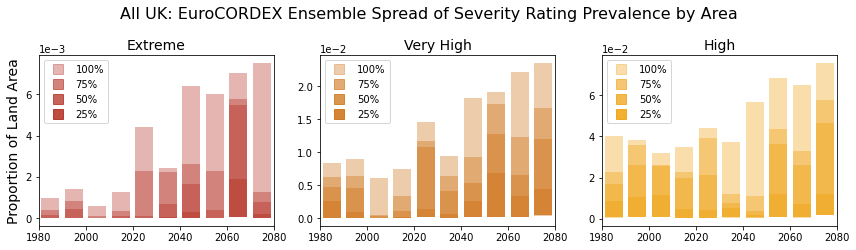

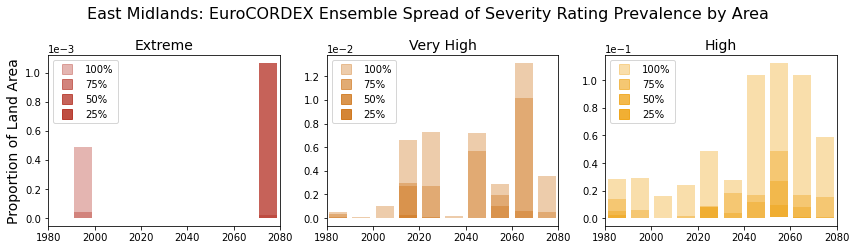

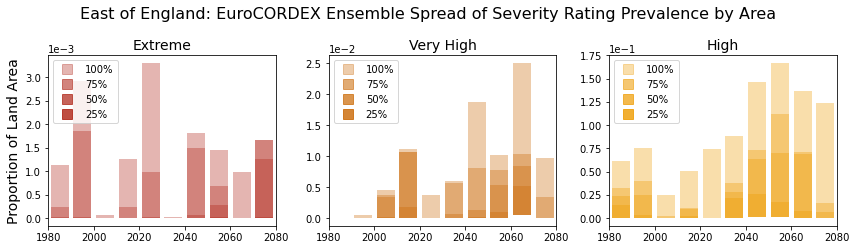

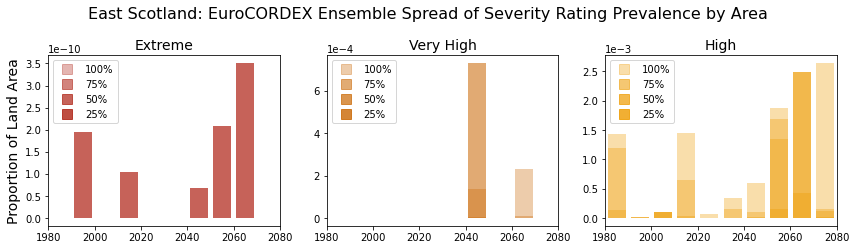

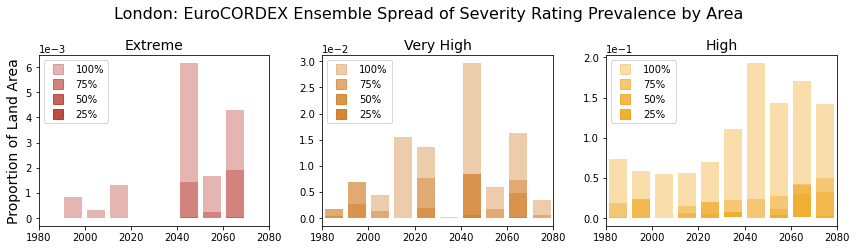

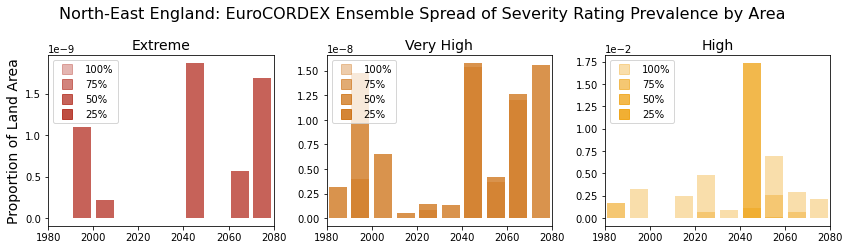

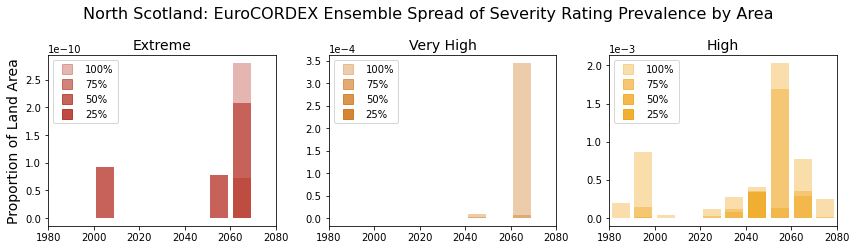

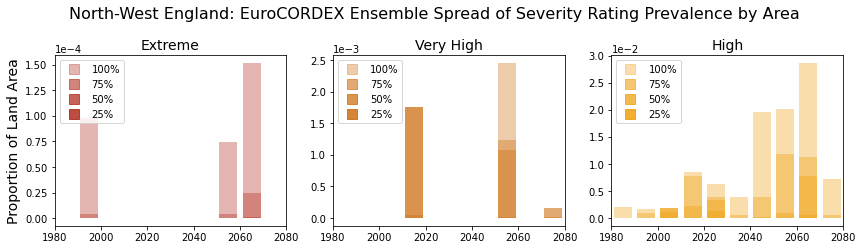

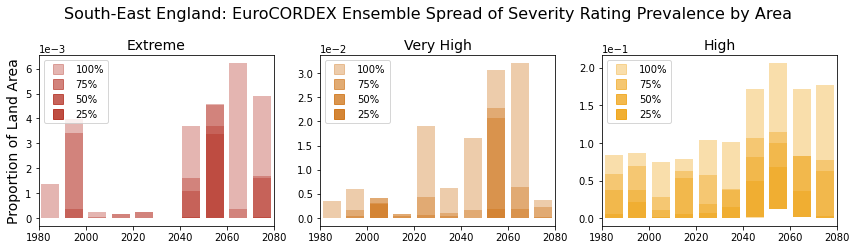

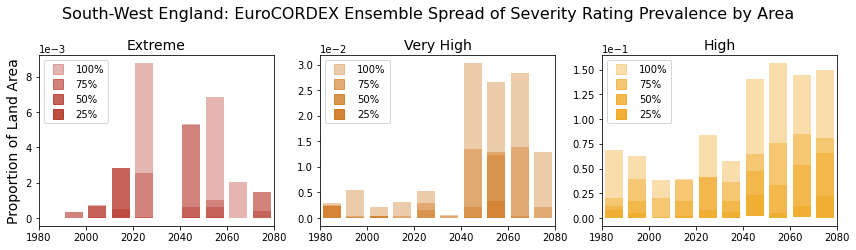

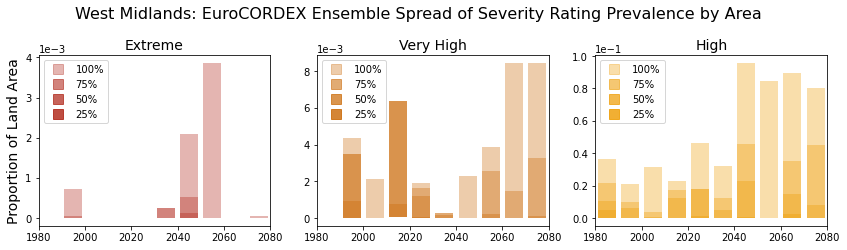

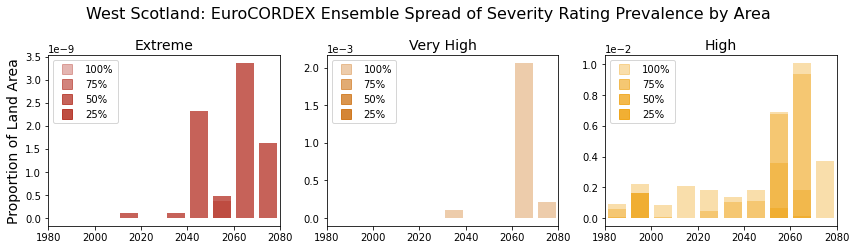

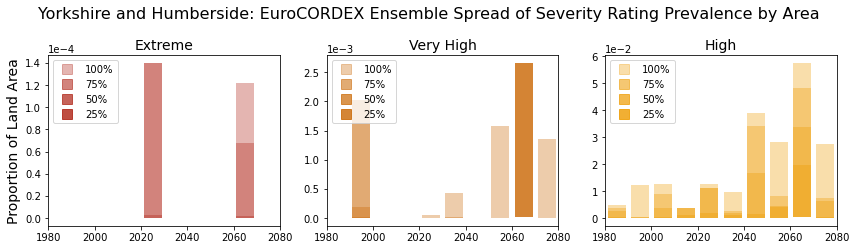

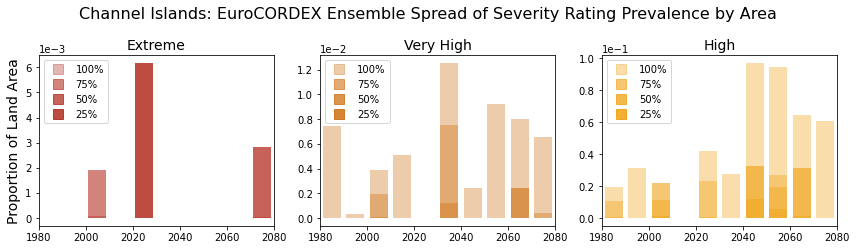

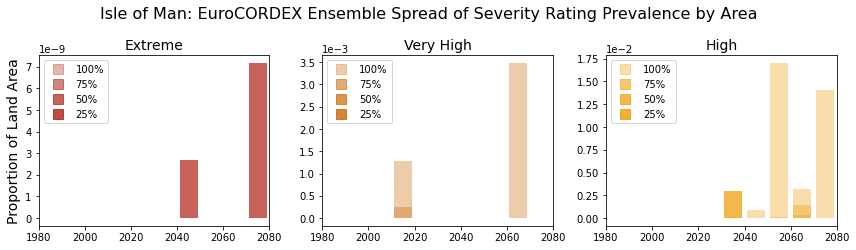

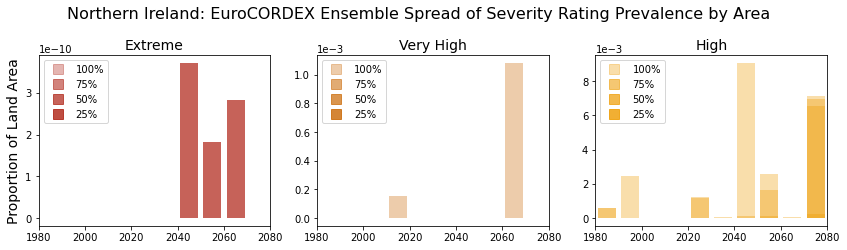

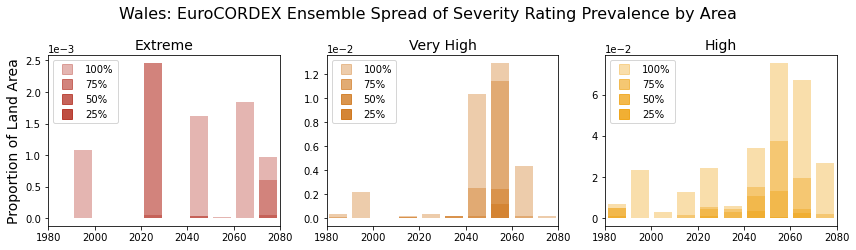

In [65]:
# Making Figure:
ids = ['All UK', 'East Midlands', 'East of England',
       'East Scotland','London','North-East England',
       'North Scotland','North-West England',
       'South-East England','South-West England',
       'West Midlands','West Scotland',
       'Yorkshire and Humberside',
       'Channel Islands',
       'Isle of Man',
       'Northern Ireland','Wales']
save_ids = ['uk', 'e_mdls', 'e_eng',
           'e_scot','ldn','ne_eng',
           'n_scot','nw_eng',
           'se_eng','sw_eng',
           'w_mdls','w_scot',
           'yorks_n_hums',
           'chnl_isl',
           'isl_man',
           'n_irln','wales']

for j in range(17):
    fig,axs = plt.subplots(1,3)
    fig.set_figheight(3.5)
    fig.set_figwidth(12)

    colours = ['#0A9396','#94D2BD','#E9D8A6','#EE9B00','#CA6702','#AE2012']

    plt.suptitle(f'{ids[j]}: EuroCORDEX Ensemble Spread of Severity Rating Prevalence by Area', fontsize=16)
    lines = {'linestyle': 'None'}
    plt.rc('lines', **lines)
    
    titles = ['Extreme','Very High','High']
    labels = ['100%','75%','50%','25%']
    base_alpha = 0.33
    
    
    l = lambda x: x+base_alpha-x*base_alpha
    alphas = [l(0)]
    for q in range(4):
        alphas.append(l(alphas[-1]))

    axs[0].set_ylabel('Proportion of Land Area',fontsize = 14)
    
    ww = 18
    
    for i in range(3):
        axs[i].errorbar(np.arange(1985,2085,10), fwi_bind_mid_100[5-i,j,:],
                        yerr=np.stack((fwi_bind_lo_100[5-i,j,:],fwi_bind_hi_100[5-i,j,:])), 
                        fmt='', color=colours[5-i], ecolor=colours[5-i], 
                        elinewidth=ww, capsize=0,alpha=base_alpha)
        handles = [mpl.lines.Line2D([], [], color=colours[5-i],alpha=alphas[p], marker='s',
                                    linestyle='None',markersize=10, 
                                    label=labels[p]) for p in range(4)]
        
        
        axs[i].errorbar(np.arange(1985,2085,10), fwi_bind_mid_75[5-i,j,:],
                        yerr=np.stack((fwi_bind_lo_75[5-i,j,:],fwi_bind_hi_75[5-i,j,:])), 
                        fmt='', color=colours[5-i], ecolor=colours[5-i], 
                        elinewidth=ww, capsize=0,alpha=base_alpha)
        
        axs[i].errorbar(np.arange(1985,2085,10), fwi_bind_mid_50[5-i,j,:],
                        yerr=np.stack((fwi_bind_lo_50[5-i,j,:],fwi_bind_hi_50[5-i,j,:])), 
                        fmt='', color=colours[5-i], ecolor=colours[5-i], 
                        elinewidth=ww, capsize=0,alpha=base_alpha)
        
        axs[i].errorbar(np.arange(1985,2085,10), fwi_bind_mid_25[5-i,j,:],
                        yerr=np.stack((fwi_bind_lo_25[5-i,j,:],fwi_bind_hi_25[5-i,j,:])), 
                        fmt='', color=colours[5-i], ecolor=colours[5-i], 
                        elinewidth=ww, capsize=0,alpha=base_alpha)
        
        axs[i].legend(handles, labels, loc='upper left')
        axs[i].xaxis.set_visible(True)
        axs[i].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        axs[i].set_xlim((1980,2080))
        axs[i].set_title(titles[i],fontsize=14)
        
    plt.tight_layout() 
    plt.savefig(f'/home/theo/final_images/2.2.images/cordex_{save_ids[j]}')
    # Set fmt='' if you don't want the line


#### UKCP18 Images

In [66]:
fwi = np.load('/home/theo/outdata/2.1.outdata/ukcp18_regional_fwi_severity_by_area.npy')
fwi = fwi/np.sum(fwi,axis=0)
print(fwi.shape)

(6, 12, 17, 100)


In [67]:
fwi_lo_100  = np.empty((6,17,100))
fwi_mid_100 = np.empty((6,17,100))
fwi_hi_100  = np.empty((6,17,100))

fwi_lo_75  = np.empty((6,17,100))
fwi_mid_75 = np.empty((6,17,100))
fwi_hi_75  = np.empty((6,17,100))

fwi_lo_50  = np.empty((6,17,100))
fwi_mid_50 = np.empty((6,17,100))
fwi_hi_50  = np.empty((6,17,100))

fwi_lo_25  = np.empty((6,17,100))
fwi_mid_25 = np.empty((6,17,100))
fwi_hi_25  = np.empty((6,17,100))

for i in range(6):
    print(f'Step {i+1} of 6')
    for j in range(100):
        if np.mod(j,10) == 0:
            print(f'Sub-step {int(j/10 + 1)} of 10')
        for k in range(17):
            
            shape, location, scale = scipy.stats.lognorm.fit(fwi[i,:,k,j])
            #x = np.linspace(scipy.stats.lognorm.ppf(0.00001, shape),scipy.stats.lognorm.ppf(0.99999, shape), 100000)
            x = np.linspace(0,2*np.max(fwi[i,:,k,j]),100000)
            cdf = scipy.stats.lognorm.cdf(x, shape, location, scale)
            pdf = scipy.stats.lognorm.pdf(x, shape, location, scale)
            
            # 100% interval:
            arg_lo_100 = np.argmin(np.absolute(cdf-0.00))
            arg_mid_100= np.argmin(np.absolute(cdf-0.50))
            arg_hi_100 = np.argmin(np.absolute(cdf-1.00))

            fwi_lo_100[i,k,j] = x[arg_lo_100]
            fwi_mid_100[i,k,j]= x[arg_mid_100]
            fwi_hi_100[i,k,j] = x[arg_hi_100]
            
            # 75% interval:
            arg_lo_75 = np.argmin(np.absolute(cdf-0.125))
            arg_mid_75= np.argmin(np.absolute(cdf-0.50))
            arg_hi_75 = np.argmin(np.absolute(cdf-0.875))

            fwi_lo_75[i,k,j] = x[arg_lo_75]
            fwi_mid_75[i,k,j]= x[arg_mid_75]
            fwi_hi_75[i,k,j] = x[arg_hi_75]
        
            # 50% interval:
            arg_lo_50 = np.argmin(np.absolute(cdf-0.25))
            arg_mid_50= np.argmin(np.absolute(cdf-0.50))
            arg_hi_50 = np.argmin(np.absolute(cdf-0.75))

            fwi_lo_50[i,k,j] = x[arg_lo_50]
            fwi_mid_50[i,k,j]= x[arg_mid_50]
            fwi_hi_50[i,k,j] = x[arg_hi_50]
        
            # 25% interval:
            arg_lo_25 = np.argmin(np.absolute(cdf-0.375))
            arg_mid_25= np.argmin(np.absolute(cdf-0.50))
            arg_hi_25 = np.argmin(np.absolute(cdf-0.625))

            fwi_lo_25[i,k,j] = x[arg_lo_25]
            fwi_mid_25[i,k,j]= x[arg_mid_25]
            fwi_hi_25[i,k,j] = x[arg_hi_25]
        
        
print(fwi_lo_25.shape,  np.min(fwi_lo_25),  np.max(fwi_lo_25))
print(fwi_mid_25.shape, np.min(fwi_mid_25), np.max(fwi_mid_25))
print(fwi_hi_25.shape,  np.min(fwi_hi_25),  np.max(fwi_hi_25))

Step 1 of 6
Sub-step 1 of 10
Sub-step 2 of 10
Sub-step 3 of 10
Sub-step 4 of 10
Sub-step 5 of 10
Sub-step 6 of 10
Sub-step 7 of 10
Sub-step 8 of 10
Sub-step 9 of 10
Sub-step 10 of 10
Step 2 of 6
Sub-step 1 of 10
Sub-step 2 of 10
Sub-step 3 of 10
Sub-step 4 of 10
Sub-step 5 of 10
Sub-step 6 of 10
Sub-step 7 of 10
Sub-step 8 of 10
Sub-step 9 of 10
Sub-step 10 of 10
Step 3 of 6
Sub-step 1 of 10
Sub-step 2 of 10
Sub-step 3 of 10
Sub-step 4 of 10
Sub-step 5 of 10
Sub-step 6 of 10
Sub-step 7 of 10
Sub-step 8 of 10
Sub-step 9 of 10
Sub-step 10 of 10
Step 4 of 6
Sub-step 1 of 10
Sub-step 2 of 10
Sub-step 3 of 10
Sub-step 4 of 10
Sub-step 5 of 10
Sub-step 6 of 10
Sub-step 7 of 10
Sub-step 8 of 10
Sub-step 9 of 10
Sub-step 10 of 10
Step 5 of 6
Sub-step 1 of 10
Sub-step 2 of 10
Sub-step 3 of 10
Sub-step 4 of 10
Sub-step 5 of 10
Sub-step 6 of 10
Sub-step 7 of 10
Sub-step 8 of 10
Sub-step 9 of 10
Sub-step 10 of 10
Step 6 of 6
Sub-step 1 of 10
Sub-step 2 of 10
Sub-step 3 of 10
Sub-step 4 of 10
Sub-s

In [69]:
# Binning Data:
n_bins = 10
bin_w  = int(100/n_bins)


uk_fwi_bind_mid_100 = np.empty((6,17,n_bins))
uk_fwi_bind_hi_100  = np.empty((6,17,n_bins))
uk_fwi_bind_lo_100  = np.empty((6,17,n_bins))
for i in range(n_bins):
    uk_fwi_bind_mid_100[:,:,i] = np.mean(fwi_mid_100[:,:,i*bin_w:(i+1)*bin_w],axis=2)
    uk_fwi_bind_hi_100[:,:,i]  = np.mean(fwi_hi_100[:,:,i*bin_w:(i+1)*bin_w],axis=2)
    uk_fwi_bind_lo_100[:,:,i]  = np.mean(fwi_lo_100[:,:,i*bin_w:(i+1)*bin_w],axis=2)

    
uk_fwi_bind_mid_75 = np.empty((6,17,n_bins))
uk_fwi_bind_hi_75  = np.empty((6,17,n_bins))
uk_fwi_bind_lo_75  = np.empty((6,17,n_bins))
for i in range(n_bins):
    uk_fwi_bind_mid_75[:,:,i] = np.mean(fwi_mid_75[:,:,i*bin_w:(i+1)*bin_w],axis=2)
    uk_fwi_bind_hi_75[:,:,i]  = np.mean(fwi_hi_75[:,:,i*bin_w:(i+1)*bin_w],axis=2)
    uk_fwi_bind_lo_75[:,:,i]  = np.mean(fwi_lo_75[:,:,i*bin_w:(i+1)*bin_w],axis=2)


uk_fwi_bind_mid_50 = np.empty((6,17,n_bins))
uk_fwi_bind_hi_50  = np.empty((6,17,n_bins))
uk_fwi_bind_lo_50  = np.empty((6,17,n_bins))
for i in range(n_bins):
    uk_fwi_bind_mid_50[:,:,i] = np.mean(fwi_mid_50[:,:,i*bin_w:(i+1)*bin_w],axis=2)
    uk_fwi_bind_hi_50[:,:,i]  = np.mean(fwi_hi_50[:,:,i*bin_w:(i+1)*bin_w],axis=2)
    uk_fwi_bind_lo_50[:,:,i]  = np.mean(fwi_lo_50[:,:,i*bin_w:(i+1)*bin_w],axis=2)
    
    
uk_fwi_bind_mid_25 = np.empty((6,17,n_bins))
uk_fwi_bind_hi_25  = np.empty((6,17,n_bins))
uk_fwi_bind_lo_25  = np.empty((6,17,n_bins))
for i in range(n_bins):
    uk_fwi_bind_mid_25[:,:,i] = np.mean(fwi_mid_25[:,:,i*bin_w:(i+1)*bin_w],axis=2)
    uk_fwi_bind_hi_25[:,:,i]  = np.mean(fwi_hi_25[:,:,i*bin_w:(i+1)*bin_w],axis=2)
    uk_fwi_bind_lo_25[:,:,i]  = np.mean(fwi_lo_25[:,:,i*bin_w:(i+1)*bin_w],axis=2)

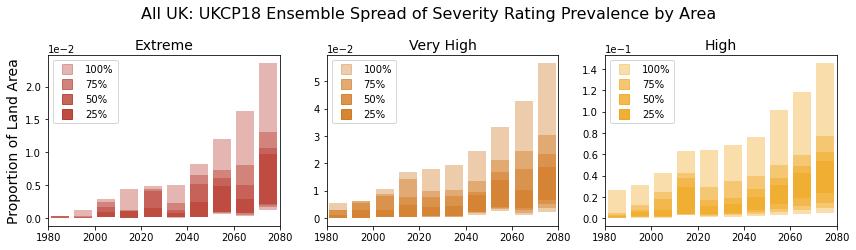

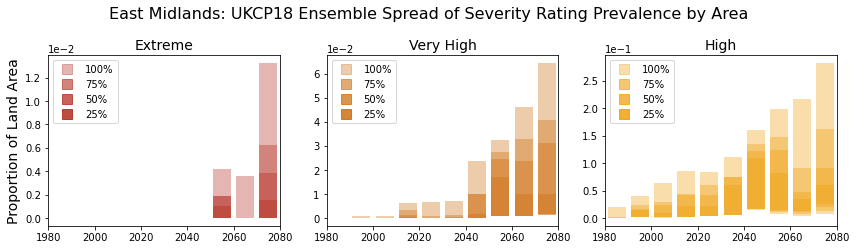

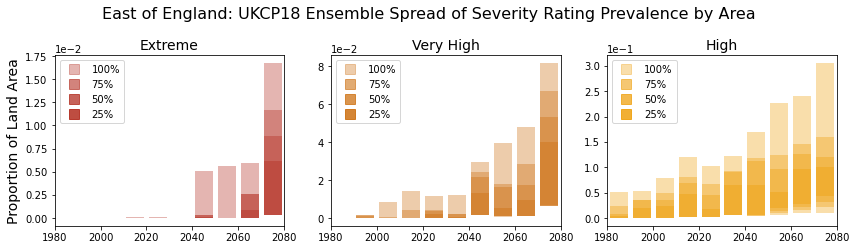

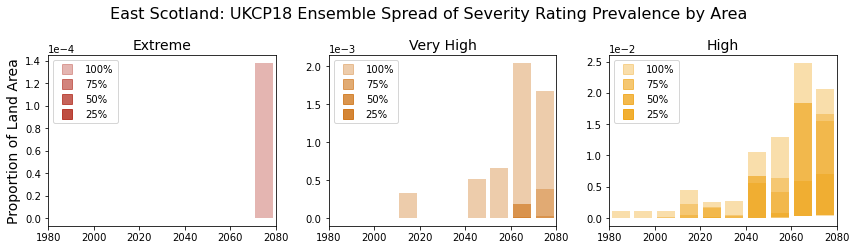

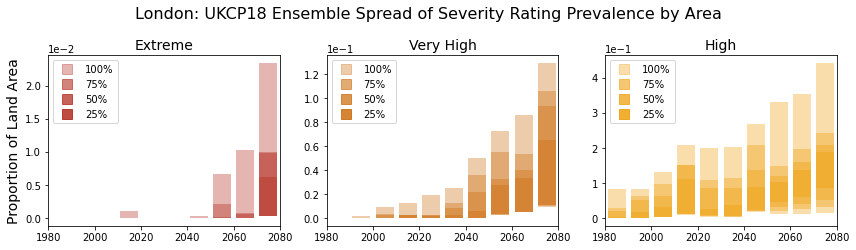

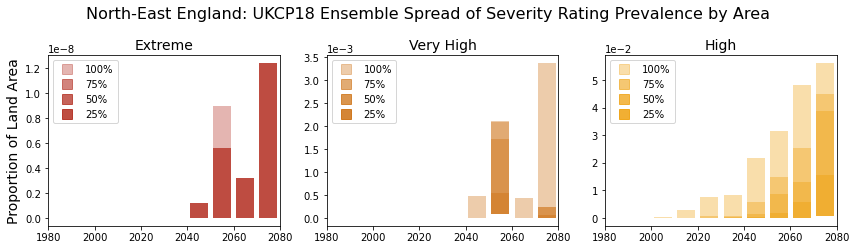

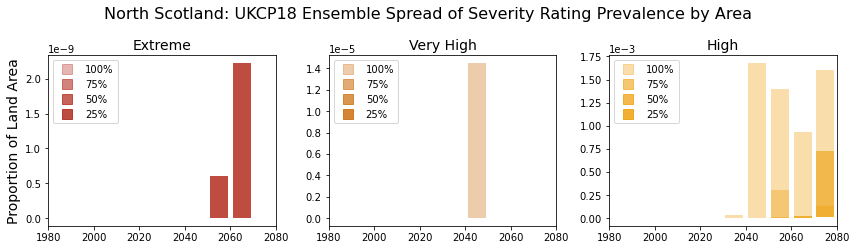

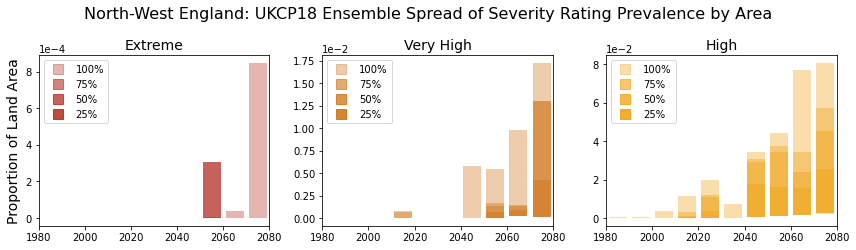

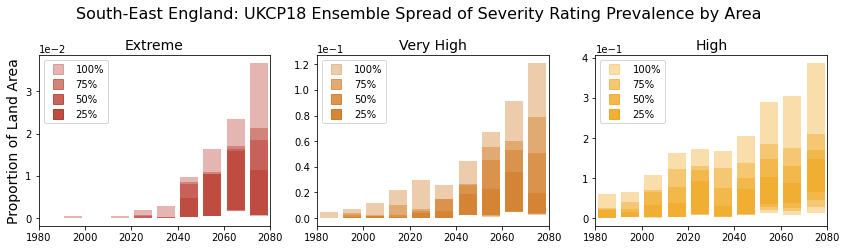

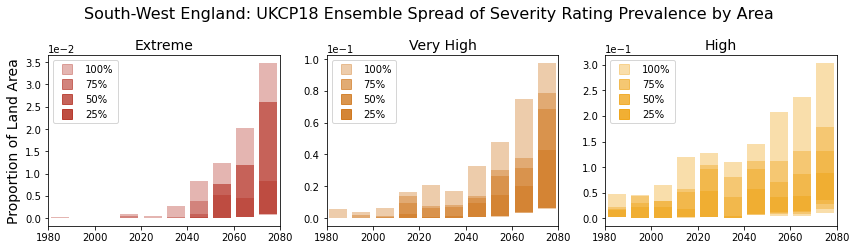

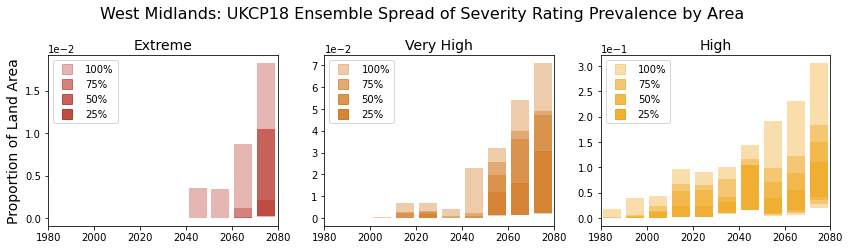

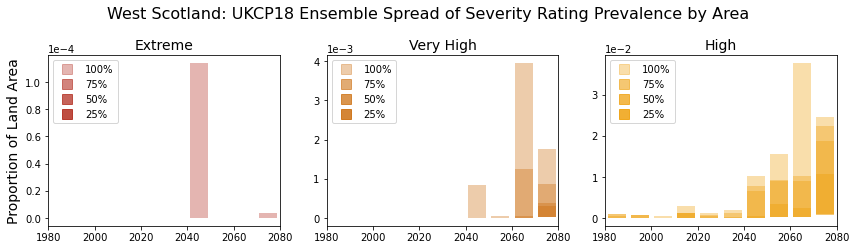

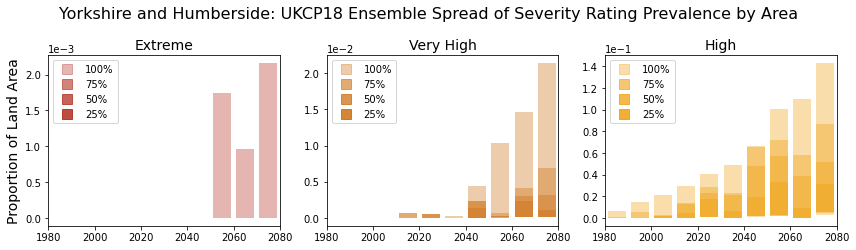

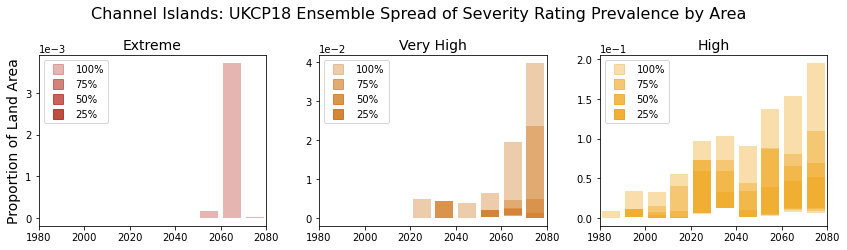

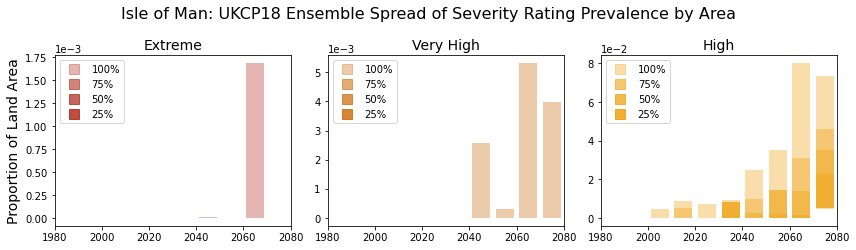

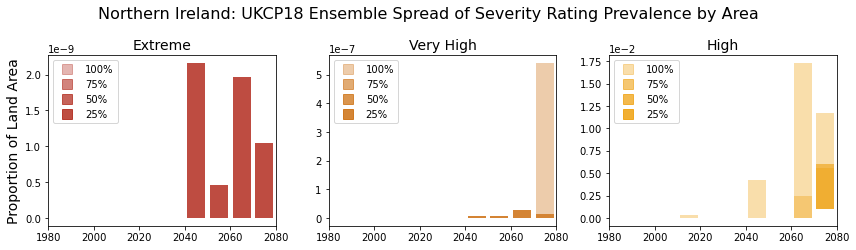

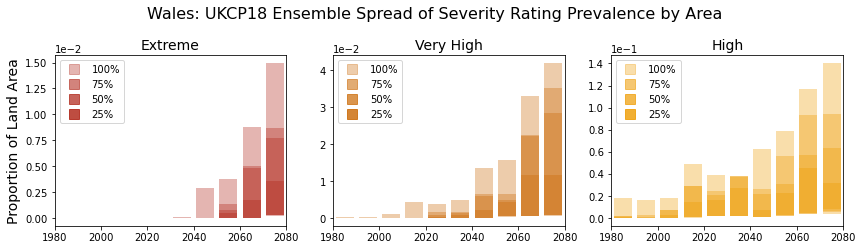

In [70]:
# Making Figure:
ids = ['All UK', 'East Midlands', 'East of England',
       'East Scotland','London','North-East England',
       'North Scotland','North-West England',
       'South-East England','South-West England',
       'West Midlands','West Scotland',
       'Yorkshire and Humberside',
       'Channel Islands',
       'Isle of Man',
       'Northern Ireland','Wales']
save_ids = ['uk', 'e_mdls', 'e_eng',
           'e_scot','ldn','ne_eng',
           'n_scot','nw_eng',
           'se_eng','sw_eng',
           'w_mdls','w_scot',
           'yorks_n_hums',
           'chnl_isl',
           'isl_man',
           'n_irln','wales']

for j in range(17):
    fig,axs = plt.subplots(1,3)
    fig.set_figheight(3.5)
    fig.set_figwidth(12)

    colours = ['#0A9396','#94D2BD','#E9D8A6','#EE9B00','#CA6702','#AE2012']

    plt.suptitle(f'{ids[j]}: UKCP18 Ensemble Spread of Severity Rating Prevalence by Area', fontsize=16)
    lines = {'linestyle': 'None'}
    plt.rc('lines', **lines)
    
    titles = ['Extreme','Very High','High']
    labels = ['100%','75%','50%','25%']
    base_alpha = 0.33
    
    
    l = lambda x: x+base_alpha-x*base_alpha
    alphas = [l(0)]
    for q in range(4):
        alphas.append(l(alphas[-1]))

    axs[0].set_ylabel('Proportion of Land Area',fontsize = 14)
    
    ww = 18
    
    for i in range(3):
        axs[i].errorbar(np.arange(1985,2085,10), uk_fwi_bind_mid_100[5-i,j,:],
                        yerr=np.stack((uk_fwi_bind_lo_100[5-i,j,:],uk_fwi_bind_hi_100[5-i,j,:])), 
                        fmt='', color=colours[5-i], ecolor=colours[5-i], 
                        elinewidth=ww, capsize=0,alpha=base_alpha)
        handles = [mpl.lines.Line2D([], [], color=colours[5-i],alpha=alphas[p], marker='s',
                                    linestyle='None',markersize=10, 
                                    label=labels[p]) for p in range(4)]
        
        
        axs[i].errorbar(np.arange(1985,2085,10), uk_fwi_bind_mid_75[5-i,j,:],
                        yerr=np.stack((uk_fwi_bind_lo_75[5-i,j,:],uk_fwi_bind_hi_75[5-i,j,:])), 
                        fmt='', color=colours[5-i], ecolor=colours[5-i], 
                        elinewidth=ww, capsize=0,alpha=base_alpha)
        
        axs[i].errorbar(np.arange(1985,2085,10), uk_fwi_bind_mid_50[5-i,j,:],
                        yerr=np.stack((uk_fwi_bind_lo_50[5-i,j,:],uk_fwi_bind_hi_50[5-i,j,:])), 
                        fmt='', color=colours[5-i], ecolor=colours[5-i], 
                        elinewidth=ww, capsize=0,alpha=base_alpha)
        
        axs[i].errorbar(np.arange(1985,2085,10), uk_fwi_bind_mid_25[5-i,j,:],
                        yerr=np.stack((uk_fwi_bind_lo_25[5-i,j,:],uk_fwi_bind_hi_25[5-i,j,:])), 
                        fmt='', color=colours[5-i], ecolor=colours[5-i], 
                        elinewidth=ww, capsize=0,alpha=base_alpha)
        
        axs[i].legend(handles, labels, loc='upper left')
        axs[i].xaxis.set_visible(True)
        axs[i].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        axs[i].set_xlim((1980,2080))
        axs[i].set_title(titles[i],fontsize=14)
        
    plt.tight_layout() 
    plt.savefig(f'/home/theo/final_images/2.2.images/ukcp18_{save_ids[j]}')
    # Set fmt='' if you don't want the line


###### Maps:

In [3]:
import scipy.stats
import math
import xarray
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings
import matplotlib as mpl
import warnings
import cmasher as cmr
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import cmasher as cmr
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FormatStrFormatter

In [4]:
def get_summer_averages(fwi_array,n):
    
    region_data  = xarray.open_dataset('/home/theo/data/ukcp18-uk-land-region-rll.nc')
    region_mask = region_data.admin_region
    region_mask = np.nan_to_num(region_mask)
    mask = np.logical_not((region_mask == 0)).astype(int)
    
    fwi_bounds = np.array([[90,5.804893137306259],
                       [99, 13.581170681055468],
                       [99.9,22.42854134637913],
                       [99.99,31.908170932956054],
                       [99.999,41.17097794179168]])
    
    print(n)
    if fwi_array.shape[1] == 36525:
        indices = np.load('/home/theo/outdata/2.2.outdata/summer_inds_36525.npy')
        beg_inds = indices[:int(365.25*20)]
        end_inds = indices[int(-365.25*20):]
    elif fwi_array.shape[1] == 36500:
        indices = np.load('/home/theo/outdata/2.2.outdata/summer_inds_36500.npy')
        beg_inds = indices[:int(365*20)]
        end_inds = indices[int(-365*20):]
    elif fwi_array.shape[1] == 36000:
        indices = np.load('/home/theo/outdata/2.2.outdata/summer_inds_36000.npy')
        beg_inds = indices[:int(360*20)]
        end_inds = indices[int(-360*20):]
    else:
        print('Could not get summer indices')
    
    fwi_array = fwi_array * mask
    
    del indices
    
    fwi_beg = np.array([np.sum(fwi_array[0,beg_inds,:,:] > fwi_bounds[0,1],axis=0),
                        np.sum(fwi_array[0,beg_inds,:,:] > fwi_bounds[1,1],axis=0),
                        np.sum(fwi_array[0,beg_inds,:,:] > fwi_bounds[2,1],axis=0),
                        np.sum(fwi_array[0,beg_inds,:,:] > fwi_bounds[3,1],axis=0),
                        np.sum(fwi_array[0,beg_inds,:,:] > fwi_bounds[4,1],axis=0)])
    fwi_end = np.array([np.sum(fwi_array[0,end_inds,:,:] > fwi_bounds[0,1],axis=0),
                        np.sum(fwi_array[0,end_inds,:,:] > fwi_bounds[1,1],axis=0),
                        np.sum(fwi_array[0,end_inds,:,:] > fwi_bounds[2,1],axis=0),
                        np.sum(fwi_array[0,end_inds,:,:] > fwi_bounds[3,1],axis=0),
                        np.sum(fwi_array[0,end_inds,:,:] > fwi_bounds[4,1],axis=0)])
    
    del beg_inds,end_inds,fwi_array
    
    return np.array([fwi_beg,fwi_end])

In [5]:
fwi_bounds = np.array([[90,5.804893137306259],
                       [99, 13.581170681055468],
                       [99.9,22.42854134637913],
                       [99.99,31.908170932956054],
                       [99.999,41.17097794179168]])
print(fwi_bounds[0,1])

5.804893137306259


In [6]:
tag = ['01','04','05','06','07','08','09','10','11','12','13','15']
cordex_plot_data = np.array([get_summer_averages(np.load(f"/data/met/fwi/ukcordex_new_fwi_{i+1}.npy"),i) 
                             for i in range(1,49)])
ukcp18_plot_data = np.array([get_summer_averages(np.load(f"/data/met/fwi/ukcp18_new_fwi_{tag[i]}.npy"),i) 
                             for i in range(12)])
cordex_plot_data = np.average(cordex_plot_data,axis=0)
ukcp18_plot_data = np.average(ukcp18_plot_data,axis=0)
np.save('/home/theo/outdata/2.2.outdata/cordex_plot_data',cordex_plot_data)
np.save('/home/theo/outdata/2.2.outdata/ukcp18_plot_data',ukcp18_plot_data)
print(ukcp18_plot_data.shape)

KeyboardInterrupt: 

In [5]:
cordex_plot_data = np.load('/home/theo/outdata/2.2.outdata/cordex_plot_data.npy')
ukcp18_plot_data = np.load('/home/theo/outdata/2.2.outdata/ukcp18_plot_data.npy')
print(cordex_plot_data.shape)
print(ukcp18_plot_data.shape)

(2, 5, 128, 108)
(2, 5, 128, 108)


In [6]:
region_data  = xarray.open_dataset('/home/theo/data/ukcp18-uk-land-region-rll.nc')
region_mask = region_data.admin_region
region_mask = np.nan_to_num(region_mask)
mask = np.logical_not((region_mask == 0)).astype(float)
print(np.unique(mask))
mask[mask == 0] = np.nan

[0. 1.]


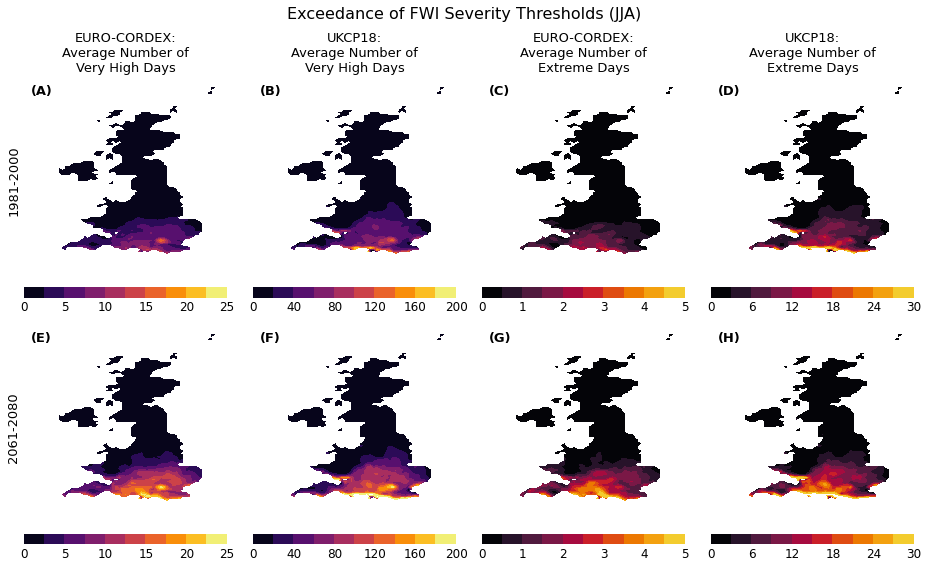

In [7]:
fig, axs = plt.subplots(2,4)
fig.set_figheight(8)
fig.set_figwidth(13)
fig.suptitle('Exceedance of FWI Severity Thresholds (JJA)', fontsize=16)

levels = np.linspace(0, 25, 10+1)
# Beginning - Very High
axs[0,0].set_ylabel('1981-2000',fontsize=13)
axs[0,0].set_title('EURO-CORDEX:\nAverage Number of\nVery High Days',fontsize=13)
data00 = (cordex_plot_data[0,3,:,:]*mask)[5:115,20:85]
c00 = axs[0,0].contourf(data00,cmap=plt.get_cmap('inferno'),levels=levels)
axs[0,0].spines['top'].set_visible(False)
axs[0,0].spines['right'].set_visible(False)
axs[0,0].spines['bottom'].set_visible(False)
axs[0,0].spines['left'].set_visible(False)
axs[0,0].get_xaxis().set_ticks([])
axs[0,0].get_yaxis().set_ticks([])
axs[0,0].text(2,100, '(A)', size=13,weight='bold')
#axs[0,0].set_facecolor('lightblue')
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb00 = fig.colorbar(c00, cax=cax, orientation='horizontal')
cb00.outline.set_visible(False)
cb00.ax.tick_params(length=0,labelsize=12)
cb00.ax.xaxis.set_major_locator(MaxNLocator(integer=True))
cb00.ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
cb00.ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = False)
cb00.set_ticks([0,5,10,15,20,25])

levels = np.linspace(0, 200, 10+1)
# Ending - Very High
axs[0,1].set_title('UKCP18:\nAverage Number of\nVery High Days',fontsize=13)
data01 = (ukcp18_plot_data[0,3,:,:]*mask)[5:115,20:85]
c01 = axs[0,1].contourf(data01,cmap=plt.get_cmap('inferno'),levels=levels)
axs[0,1].spines['top'].set_visible(False)
axs[0,1].spines['right'].set_visible(False)
axs[0,1].spines['bottom'].set_visible(False)
axs[0,1].spines['left'].set_visible(False)
axs[0,1].get_xaxis().set_ticks([])
axs[0,1].get_yaxis().set_ticks([])
axs[0,1].text(2,100, '(B)', size=13,weight='bold')
#axs[0,1].set_facecolor('lightblue')
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb01 = fig.colorbar(c01, cax=cax, orientation='horizontal')
cb01.outline.set_visible(False)
cb01.ax.tick_params(length=0,labelsize=12)
cb01.ax.xaxis.set_major_locator(MaxNLocator(integer=True))
cb01.ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
cb01.ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = False)
cb01.set_ticks([0,40,80,120,160,200])

levels = np.linspace(0, 5, 10+1)
# Beginning - Very High
axs[0,2].set_title('EURO-CORDEX:\nAverage Number of\nExtreme Days',fontsize=13)
data02 = (cordex_plot_data[0,4,:,:]*mask)[5:115,20:85]
c02 = axs[0,2].contourf(data02,cmap=plt.get_cmap('cmr.ember'),levels=levels)
axs[0,2].spines['top'].set_visible(False)
axs[0,2].spines['right'].set_visible(False)
axs[0,2].spines['bottom'].set_visible(False)
axs[0,2].spines['left'].set_visible(False)
axs[0,2].get_xaxis().set_ticks([])
axs[0,2].get_yaxis().set_ticks([])
axs[0,2].text(2,100, '(C)', size=13,weight='bold')
#axs[0,2].set_facecolor('lightblue')
divider = make_axes_locatable(axs[0,2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb02 = fig.colorbar(c02, cax=cax, orientation='horizontal')
cb02.outline.set_visible(False)
cb02.ax.tick_params(length=0,labelsize=12)
cb02.ax.xaxis.set_major_locator(MaxNLocator(integer=True))
cb02.ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
cb02.ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = False)
cb02.set_ticks([0,1,2,3,4,5])

levels = np.linspace(0, 30, 10+1)
# Ending - Very High
axs[0,3].set_title('UKCP18:\nAverage Number of\nExtreme Days',fontsize=13)
data03 = (ukcp18_plot_data[0,4,:,:]*mask)[5:115,20:85]
c03 = axs[0,3].contourf(data03,cmap=plt.get_cmap('cmr.ember'),levels=levels)
axs[0,3].spines['top'].set_visible(False)
axs[0,3].spines['right'].set_visible(False)
axs[0,3].spines['bottom'].set_visible(False)
axs[0,3].spines['left'].set_visible(False)
axs[0,3].get_xaxis().set_ticks([])
axs[0,3].get_yaxis().set_ticks([])
axs[0,3].text(2,100, '(D)', size=13,weight='bold')
#axs[0,3].set_facecolor('lightblue')
tick_locator = mpl.ticker.MaxNLocator(nbins=5)
cb01.locator = tick_locator
divider = make_axes_locatable(axs[0,3])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb03 = fig.colorbar(c03, cax=cax, orientation='horizontal')
cb03.outline.set_visible(False)
cb03.ax.tick_params(length=0,labelsize=12)
cb03.ax.xaxis.set_major_locator(MaxNLocator(integer=True))
cb03.ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
cb03.ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = False)
cb03.set_ticks([0,6,12,18,24,30])



levels = np.linspace(0, 25, 10+1)
# Beginning - Very High
data00 = (cordex_plot_data[1,3,:,:]*mask)[5:115,20:85]
c00 = axs[1,0].contourf(data00,cmap=plt.get_cmap('inferno'),levels=levels)
axs[1,0].spines['top'].set_visible(False)
axs[1,0].spines['right'].set_visible(False)
axs[1,0].spines['bottom'].set_visible(False)
axs[1,0].spines['left'].set_visible(False)
axs[1,0].get_xaxis().set_ticks([])
axs[1,0].get_yaxis().set_ticks([])
axs[1,0].set_ylabel('2061-2080',fontsize=13)
axs[1,0].text(2,100, '(E)', size=13,weight='bold')
#axs[1,0].set_facecolor('lightblue')
divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb00 = fig.colorbar(c00, cax=cax, orientation='horizontal')
cb00.outline.set_visible(False)
cb00.ax.tick_params(length=0,labelsize=12)
cb00.ax.xaxis.set_major_locator(MaxNLocator(integer=True))
cb00.ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
cb00.ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = False)
cb00.set_ticks([0,5,10,15,20,25])

levels = np.linspace(0, 200, 10+1)
# Ending - Very High
data01 = (ukcp18_plot_data[1,3,:,:]*mask)[5:115,20:85]
c01 = axs[1,1].contourf(data01,cmap=plt.get_cmap('inferno'),levels=levels)
axs[1,1].spines['top'].set_visible(False)
axs[1,1].spines['right'].set_visible(False)
axs[1,1].spines['bottom'].set_visible(False)
axs[1,1].spines['left'].set_visible(False)
axs[1,1].get_xaxis().set_ticks([])
axs[1,1].get_yaxis().set_ticks([])
axs[1,1].text(2,100, '(F)', size=13,weight='bold')
#axs[1,1].set_facecolor('lightblue')
tick_locator = mpl.ticker.MaxNLocator(nbins=5)
cb01.locator = tick_locator
divider = make_axes_locatable(axs[1,1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb01 = fig.colorbar(c01, cax=cax, orientation='horizontal')
cb01.outline.set_visible(False)
cb01.ax.tick_params(length=0,labelsize=12)
cb01.ax.xaxis.set_major_locator(MaxNLocator(integer=True))
cb01.ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
cb01.ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = False)
cb01.set_ticks([0,40,80,120,160,200])

levels = np.linspace(0, 5, 10+1)
# Beginning - Very High
data02 = (cordex_plot_data[1,4,:,:]*mask)[5:115,20:85]
c02 = axs[1,2].contourf(data02,cmap=plt.get_cmap('cmr.ember'),levels=levels)
axs[1,2].spines['top'].set_visible(False)
axs[1,2].spines['right'].set_visible(False)
axs[1,2].spines['bottom'].set_visible(False)
axs[1,2].spines['left'].set_visible(False)
axs[1,2].get_xaxis().set_ticks([])
axs[1,2].get_yaxis().set_ticks([])
axs[1,2].text(2,100, '(G)', size=13,weight='bold')
#axs[1,2].set_facecolor('lightblue')
divider = make_axes_locatable(axs[1,2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb02 = fig.colorbar(c02, cax=cax, orientation='horizontal')
cb02.outline.set_visible(False)
cb02.ax.tick_params(length=0,labelsize=12)
cb02.ax.xaxis.set_major_locator(MaxNLocator(integer=True))
cb02.ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
cb02.ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = False)
cb02.set_ticks([0,1,2,3,4,5])

levels = np.linspace(0, 30, 10+1)
# Ending - Very High
data03 = (ukcp18_plot_data[1,4,:,:]*mask)[5:115,20:85]
c03 = axs[1,3].contourf(data03,cmap=plt.get_cmap('cmr.ember'),levels=levels)
axs[1,3].spines['top'].set_visible(False)
axs[1,3].spines['right'].set_visible(False)
axs[1,3].spines['bottom'].set_visible(False)
axs[1,3].spines['left'].set_visible(False)
axs[1,3].get_xaxis().set_ticks([])
axs[1,3].get_yaxis().set_ticks([])
axs[1,3].text(2,100, '(H)', size=13,weight='bold')
#axs[1,3].set_facecolor('lightblue')
tick_locator = mpl.ticker.MaxNLocator(nbins=5)
cb01.locator = tick_locator
divider = make_axes_locatable(axs[1,3])
cax = divider.append_axes('bottom', size='5%', pad=0.05)

cb03 = fig.colorbar(c03, cax=cax, orientation='horizontal')
cb03.outline.set_visible(False)
cb03.ax.tick_params(length=0,labelsize=12)
cb03.ax.xaxis.set_major_locator(MaxNLocator(integer=True))
cb03.ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
cb03.ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = False)
cb03.set_ticks([0,6,12,18,24,30])

plt.tight_layout()
plt.savefig('/home/theo/final_images/2.2.images/_FWI_MAPS')

In [22]:
import sys
np.set_printoptions(threshold=sys.maxsize)
print(np.sum((cordex_plot_data[1,2,:,:]*mask)>125))

10


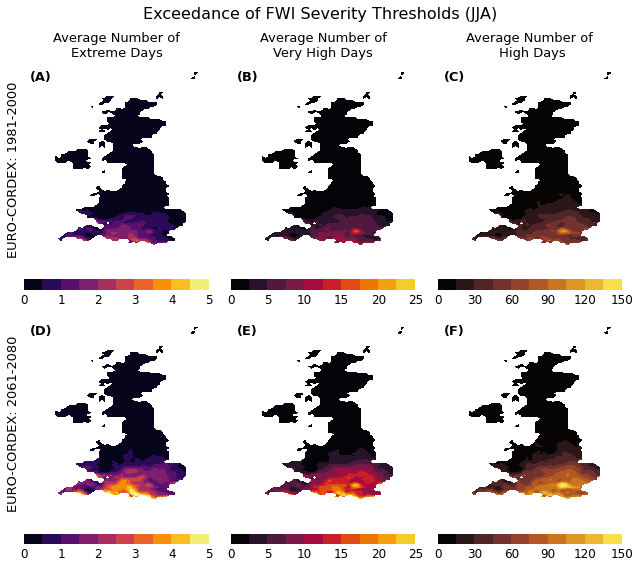

In [11]:
fig, axs = plt.subplots(2,3)
fig.set_figheight(8)
fig.set_figwidth(9)
fig.suptitle('Exceedance of FWI Severity Thresholds (JJA)', fontsize=16)



levels = np.linspace(0, 5, 10+1)
# Beginning - Very High
axs[0,0].set_title('Average Number of\nExtreme Days',fontsize=13)
data00 = (cordex_plot_data[0,4,:,:]*mask)[5:115,20:85]
c00 = axs[0,0].contourf(data00,cmap=plt.get_cmap('inferno'),levels=levels)
axs[0,0].spines['top'].set_visible(False)
axs[0,0].spines['right'].set_visible(False)
axs[0,0].spines['bottom'].set_visible(False)
axs[0,0].spines['left'].set_visible(False)
axs[0,0].get_xaxis().set_ticks([])
axs[0,0].get_yaxis().set_ticks([])
axs[0,0].set_ylabel('EURO-CORDEX: 1981-2000',fontsize=13)
axs[0,0].text(2,100, '(A)', size=13,weight='bold')
#axs[0,0].set_facecolor('lightblue')
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb00 = fig.colorbar(c00, cax=cax, orientation='horizontal')
cb00.outline.set_visible(False)
cb00.ax.tick_params(length=0,labelsize=12)
cb00.ax.xaxis.set_major_locator(MaxNLocator(integer=True))
cb00.ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
cb00.ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = False)
cb00.set_ticks([0,1,2,3,4,5])

levels = np.linspace(0, 5, 10+1)
# Ending - Very High
axs[1,0].set_ylabel('EURO-CORDEX: 2061-2080',fontsize=13)
data01 = (cordex_plot_data[1,4,:,:]*mask)[5:115,20:85]
c01 = axs[1,0].contourf(data01,cmap=plt.get_cmap('inferno'),levels=levels)
axs[1,0].spines['top'].set_visible(False)
axs[1,0].spines['right'].set_visible(False)
axs[1,0].spines['bottom'].set_visible(False)
axs[1,0].spines['left'].set_visible(False)
axs[1,0].get_xaxis().set_ticks([])
axs[1,0].get_yaxis().set_ticks([])
axs[1,0].text(2,100, '(D)', size=13,weight='bold')
#axs[1,0].set_facecolor('lightblue')
divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb01 = fig.colorbar(c01, cax=cax, orientation='horizontal')
cb01.outline.set_visible(False)
cb01.ax.tick_params(length=0,labelsize=12)
cb01.ax.xaxis.set_major_locator(MaxNLocator(integer=True))
cb01.ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
cb01.ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = False)
cb01.set_ticks([0,1,2,3,4,5])



levels = np.linspace(0, 25, 10+1)
# Beginning - Very High
axs[0,1].set_title('Average Number of\nVery High Days',fontsize=13)
data10 = (cordex_plot_data[0,3,:,:]*mask)[5:115,20:85]
c10 = axs[0,1].contourf(data10,cmap=plt.get_cmap('cmr.ember'),levels=levels)
axs[0,1].spines['top'].set_visible(False)
axs[0,1].spines['right'].set_visible(False)
axs[0,1].spines['bottom'].set_visible(False)
axs[0,1].spines['left'].set_visible(False)
axs[0,1].get_xaxis().set_ticks([])
axs[0,1].get_yaxis().set_ticks([])
axs[0,1].text(2,100, '(B)', size=13,weight='bold')
#axs[0,1].set_facecolor('lightblue')
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb10 = fig.colorbar(c10, cax=cax, orientation='horizontal')
cb10.outline.set_visible(False)
cb10.ax.tick_params(length=0,labelsize=12)
cb10.ax.xaxis.set_major_locator(MaxNLocator(integer=True))
cb10.ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
cb10.ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = False)
cb10.set_ticks([0,5,10,15,20,25])

levels = np.linspace(0, 25, 10+1)
# Ending - Very High
data11 = (cordex_plot_data[1,3,:,:]*mask)[5:115,20:85]
c11 = axs[1,1].contourf(data11,cmap=plt.get_cmap('cmr.ember'),levels=levels)
axs[1,1].spines['top'].set_visible(False)
axs[1,1].spines['right'].set_visible(False)
axs[1,1].spines['bottom'].set_visible(False)
axs[1,1].spines['left'].set_visible(False)
axs[1,1].get_xaxis().set_ticks([])
axs[1,1].get_yaxis().set_ticks([])
axs[1,1].text(2,100, '(E)', size=13,weight='bold')
#axs[1,1].set_facecolor('lightblue')
divider = make_axes_locatable(axs[1,1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb11 = fig.colorbar(c11, cax=cax, orientation='horizontal')
cb11.outline.set_visible(False)
cb11.ax.tick_params(length=0,labelsize=12)
cb11.ax.xaxis.set_major_locator(MaxNLocator(integer=True))
cb11.ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
cb11.ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = False)
cb11.set_ticks([0,5,10,15,20,25])


levels = np.linspace(0, 150, 10+1)
# Beginning - Very High
axs[0,2].set_title('Average Number of\n High Days',fontsize=13)
data20 = (cordex_plot_data[0,2,:,:]*mask)[5:115,20:85]
c20 = axs[0,2].contourf(data20,cmap=plt.get_cmap('cmr.amber'),levels=levels)
axs[0,2].spines['top'].set_visible(False)
axs[0,2].spines['right'].set_visible(False)
axs[0,2].spines['bottom'].set_visible(False)
axs[0,2].spines['left'].set_visible(False)
axs[0,2].get_xaxis().set_ticks([])
axs[0,2].get_yaxis().set_ticks([])
axs[0,2].text(2,100, '(C)', size=13,weight='bold')
#axs[0,2].set_facecolor('lightblue')
divider = make_axes_locatable(axs[0,2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb20 = fig.colorbar(c20, cax=cax, orientation='horizontal')
cb20.outline.set_visible(False)
cb20.ax.tick_params(length=0,labelsize=12)
cb20.ax.xaxis.set_major_locator(MaxNLocator(integer=True))
cb20.ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
cb20.ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = False)
cb20.set_ticks([0,30,60,90,120,150])

levels = np.linspace(0, 150, 10+1)
# Ending - Very High
data21 = (cordex_plot_data[1,2,:,:]*mask)[5:115,20:85]
c21 = axs[1,2].contourf(data21,cmap=plt.get_cmap('cmr.amber'),levels=levels)
axs[1,2].spines['top'].set_visible(False)
axs[1,2].spines['right'].set_visible(False)
axs[1,2].spines['bottom'].set_visible(False)
axs[1,2].spines['left'].set_visible(False)
axs[1,2].get_xaxis().set_ticks([])
axs[1,2].get_yaxis().set_ticks([])
axs[1,2].text(2,100, '(F)', size=13,weight='bold')
#axs[1,2].set_facecolor('lightblue')
divider = make_axes_locatable(axs[1,2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb21 = fig.colorbar(c21, cax=cax, orientation='horizontal')
cb21.outline.set_visible(False)
cb21.ax.tick_params(length=0,labelsize=12)
cb21.ax.xaxis.set_major_locator(MaxNLocator(integer=True))
cb21.ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
cb21.ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = False)
cb21.set_ticks([0,30,60,90,120,150])



plt.tight_layout()
plt.savefig('/home/theo/final_images/2.2.images/_FWI_MAPS_CORDEX')

(array([1.129e+03, 1.790e+02, 1.400e+02, 1.030e+02, 3.900e+01, 3.900e+01,
        2.000e+01, 6.000e+00, 1.000e+00, 3.000e+00]),
 array([0.     , 0.63125, 1.2625 , 1.89375, 2.525  , 3.15625, 3.7875 ,
        4.41875, 5.05   , 5.68125, 6.3125 ]),
 <BarContainer object of 10 artists>)

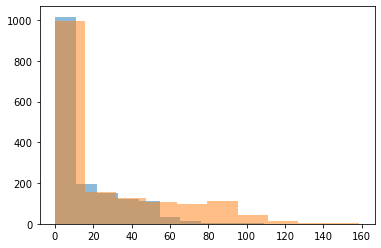

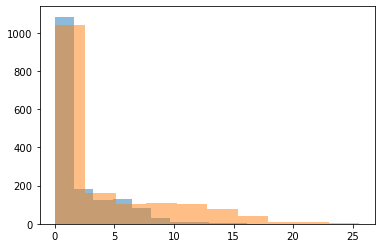

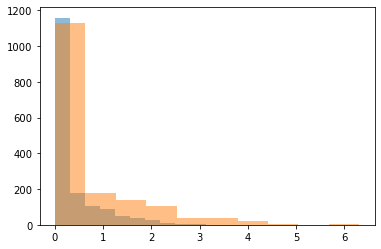

In [17]:
plt.figure()
plt.hist((cordex_plot_data[0,2,:,:]*mask).flatten(),alpha=0.5)
plt.hist((cordex_plot_data[1,2,:,:]*mask).flatten(),alpha=0.5)
plt.figure()
plt.hist((cordex_plot_data[0,3,:,:]*mask).flatten(),alpha=0.5)
plt.hist((cordex_plot_data[1,3,:,:]*mask).flatten(),alpha=0.5)
plt.figure()
plt.hist((cordex_plot_data[0,4,:,:]*mask).flatten(),alpha=0.5)
plt.hist((cordex_plot_data[1,4,:,:]*mask).flatten(),alpha=0.5)

<ipython-input-27-fb95c5f10b82>:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.hist((cordex_plot_data[1,2,:,:]*mask).flatten()/(cordex_plot_data[0,2,:,:]*mask).flatten(),alpha=0.5,range=(0,4),bins=100)
<ipython-input-27-fb95c5f10b82>:2: RuntimeWarning: invalid value encountered in true_divide
  plt.hist((cordex_plot_data[1,2,:,:]*mask).flatten()/(cordex_plot_data[0,2,:,:]*mask).flatten(),alpha=0.5,range=(0,4),bins=100)
<ipython-input-27-fb95c5f10b82>:3: RuntimeWarning: divide by zero encountered in true_divide
  print(np.nanmean((cordex_plot_data[1,2,:,:]*mask).flatten()/(cordex_plot_data[0,2,:,:]*mask).flatten()))
<ipython-input-27-fb95c5f10b82>:3: RuntimeWarning: invalid value encountered in true_divide
  print(np.nanmean((cordex_plot_data[1,2,:,:]*mask).flatten()/(cordex_plot_data[0,2,:,:]*mask).flatten()))
<ipython-input-27-fb95c5f10b82>:5: RuntimeWarning: divide by zero encountered in true_divide
  plt.hist((cordex_plot_data[1,3,:,:]*mask).flatten()/(cordex_plo

inf


<ipython-input-27-fb95c5f10b82>:8: RuntimeWarning: divide by zero encountered in true_divide
  plt.hist((cordex_plot_data[1,4,:,:]*mask).flatten()/(cordex_plot_data[0,4,:,:]*mask).flatten(),alpha=0.5,range=(0,4),bins=100)
<ipython-input-27-fb95c5f10b82>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.hist((cordex_plot_data[1,4,:,:]*mask).flatten()/(cordex_plot_data[0,4,:,:]*mask).flatten(),alpha=0.5,range=(0,4),bins=100)


(array([ 2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0., 25.,
         0.,  0.,  0.,  1.,  2.,  0.,  1.,  6.,  0.,  4.,  3., 12.,  5.,
         6.,  7., 21., 20., 22., 24., 26., 33., 27., 21., 26., 67., 29.,
        28., 16., 26., 21., 15., 18., 16., 16., 22., 12., 37., 13., 13.,
        18., 17., 11., 19.,  7., 16.,  7.,  6.,  5.,  1., 36.,  2.,  3.,
         2.,  5.,  1.,  6.,  2.,  2.,  1.,  3.,  1., 11.,  1.,  1.,  1.,
         3.,  1.,  3.,  0.,  1.,  1.,  0.,  0., 11.]),
 array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
        0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
        0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28,
        1.32, 1.36, 1.4 , 1.44, 1.48, 1.52, 1.56, 1.6 , 1.64, 1.68, 1.72,
        1.76, 1.8 , 1.84, 1.88, 1.92, 1.96, 2.  , 2.04, 2.08, 2.12, 2.16,
        2.2 , 2.24, 2.28, 2.32, 2.36, 2.4 , 2.44, 2.48, 2.52, 2.

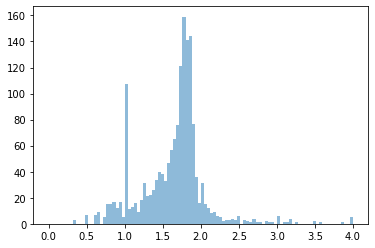

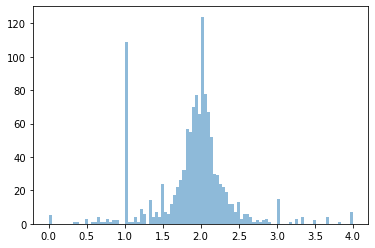

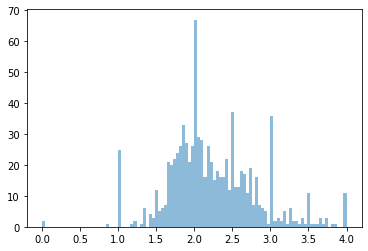

In [27]:
plt.figure()
plt.hist((cordex_plot_data[1,2,:,:]*mask).flatten()/(cordex_plot_data[0,2,:,:]*mask).flatten(),alpha=0.5,range=(0,4),bins=100)
print(np.nanmean((cordex_plot_data[1,2,:,:]*mask).flatten()/(cordex_plot_data[0,2,:,:]*mask).flatten()))
plt.figure()
plt.hist((cordex_plot_data[1,3,:,:]*mask).flatten()/(cordex_plot_data[0,3,:,:]*mask).flatten(),alpha=0.5,range=(0,4),bins=100)

plt.figure()
plt.hist((cordex_plot_data[1,4,:,:]*mask).flatten()/(cordex_plot_data[0,4,:,:]*mask).flatten(),alpha=0.5,range=(0,4),bins=100)